In [172]:
!pip install statsmodels

In [173]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')



# DATA PREPARATION

In [174]:
### CHANGE NAME OF FOLDER AND FILES TO CORRESPOND ####
all_data_df = pd.read_csv("./Data/Data.csv")
ss = pd.read_csv("SampleSubmission.csv")

In [175]:
### CHANGE NAME OF FOLDER AND FILES TO CORRESPOND ####
climate_data=pd.read_excel("./ClimateData/Climate Data/Kalam Climate Data.xlsx")
climate_data.head

<bound method NDFrame.head of                 Date Time  Temperature (°C)  Dewpoint Temperature (°C)  \
0     2023-06-03 13:00:00          7.199731                  -2.448126   
1     2023-06-03 14:00:00          6.000620                  -2.597540   
2     2023-06-03 15:00:00          4.789972                  -2.696951   
3     2023-06-03 16:00:00          3.158746                  -2.879324   
4     2023-06-03 17:00:00          1.671426                  -3.255606   
...                   ...               ...                        ...   
12223 2024-10-24 20:00:00         -5.387305                  -5.942435   
12224 2024-10-24 21:00:00         -6.008307                  -6.837256   
12225 2024-10-24 22:00:00         -6.535742                  -7.863989   
12226 2024-10-24 23:00:00         -6.864859                  -8.328970   
12227 2024-10-25 00:00:00         -7.224661                  -8.735220   

       U Wind Component (m/s)  V Wind Component (m/s)  \
0                   -0.0

In [176]:
# Count the number of missing values per feature
missing_values = climate_data.isnull().sum()

# Display columns with missing values and their count
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [177]:
# Split 'Source' into 'consumer_device_X' and 'data_user_Y'
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

# Display the updated DataFrame to check
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x,consumer_device,data_user
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1


In [178]:
# for all_data["Source"] aggregate by sum on day
# Assuming 'all_data_df' is already defined as in your previous code.
# Convert 'Datetime' column to datetime objects if it's not already
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])

# Extract the date part
all_data_df['Date'] = all_data_df['date_time'].dt.date

# Group by 'Source' and 'Date', then sum the 'Load' for each group
aggregated_data = all_data_df.groupby(['Source', 'Date'])['kwh'].sum().reset_index()

# Display the aggregated data
aggregated_data.head()


,Source,Date,kwh
0,consumer_device_10_data_user_1,2024-07-22,0.024330
1,consumer_device_10_data_user_1,2024-07-23,0.103560
2,consumer_device_10_data_user_1,2024-07-24,0.137543
3,consumer_device_10_data_user_1,2024-07-25,0.121011
4,consumer_device_10_data_user_1,2024-07-26,0.000000


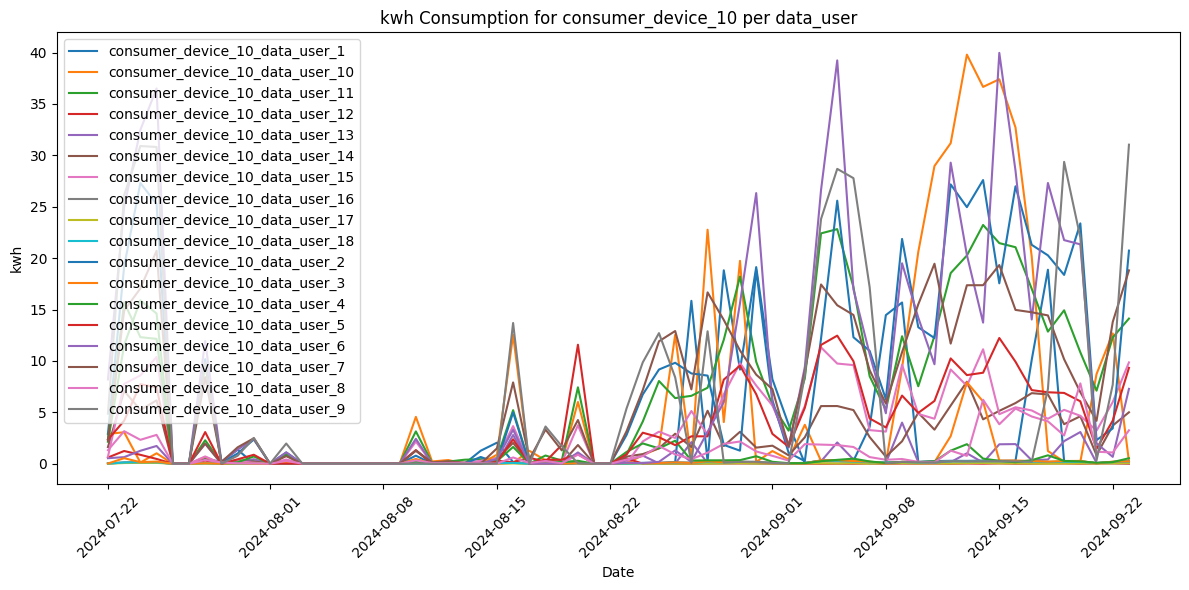

In [179]:
# CHECK OF THE DATA
consumer_10_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_10')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_10_data['Source'].unique():
    user_data = consumer_10_data[consumer_10_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [180]:
# Find the minimum and maximum date_time values
min_date = aggregated_data['Date'].min()
max_date = aggregated_data['Date'].max()

print(f"Minimum date_time: {min_date}")
print(f"Maximum date_time: {max_date}")

Minimum date_time: 2023-06-03
Maximum date_time: 2024-09-23


In [181]:
## CODE FOR DROPPING or filling with 0, the dates unavailable in data
# Create a date range
date_rng = pd.date_range(start=min_date, end=max_date, freq='D')

# Create an empty DataFrame to store the complete data
complete_data = pd.DataFrame()

# Iterate through each unique 'Source'
for source in aggregated_data['Source'].unique():
    # Extract data for the current 'Source'
    source_data = aggregated_data[aggregated_data['Source'] == source].copy()

    # Convert the source data Date to match the type of date_rng
    source_data['Date'] = pd.to_datetime(source_data['Date'])

    # Create a complete date range for the current 'Source'
    source_date_rng = pd.DataFrame({'Date': date_rng})
    source_date_rng['Source'] = source
    source_data = pd.merge(source_date_rng, source_data, on=['Date', 'Source'], how='left')
    # source_data['kwh'] = source_data['kwh'].fillna(0)
    source_data = source_data.dropna()
    # Append to the complete data
    complete_data = pd.concat([complete_data, source_data], ignore_index=True)

In [182]:
##### CLIMATE DATA SETUP
climate_df = pd.read_excel("./ClimateData/Climate Data/Kalam Climate Data.xlsx")# Convert to datetime
complete_data["Date"] = pd.to_datetime(complete_data["Date"])
climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])

# Aggregate climate data to daily level
climate_daily = climate_df.groupby(climate_df["Date Time"].dt.date).agg({
    "Temperature (°C)": "mean",
    "Dewpoint Temperature (°C)": "mean",
    "U Wind Component (m/s)": "mean",
    "V Wind Component (m/s)": "mean",
    "Total Precipitation (mm)": "sum",
    "Snowfall (mm)": "sum",
    "Snow Cover (%)": "mean",
}).reset_index()

# Convert 'Date' column in climate_daily to datetime format
climate_daily.rename(columns={"Date Time": "Date"}, inplace=True)
climate_daily["Date"] = pd.to_datetime(climate_daily["Date"])  # Ensure datetime64[ns]

# Merge with complete_data
complete_data = complete_data.merge(climate_daily, on="Date", how="left")

In [183]:
complete_data

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
0,2024-07-22,consumer_device_10_data_user_1,0.024330,14.719596,8.280669,0.022655,-0.104998,0.073049,0.000000,0.000000
1,2024-07-23,consumer_device_10_data_user_1,0.103560,13.217268,9.862700,0.116137,-0.077997,0.121921,0.000000,0.000000
2,2024-07-24,consumer_device_10_data_user_1,0.137543,12.462190,9.865658,0.103451,-0.075028,0.119984,0.000000,0.000000
3,2024-07-25,consumer_device_10_data_user_1,0.121011,13.867551,8.973798,0.066345,-0.043182,0.034283,0.000000,0.000000
4,2024-07-26,consumer_device_10_data_user_1,0.000000,15.572609,9.434734,0.093025,0.046414,0.006961,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
136404,2024-09-10,consumer_device_9_data_user_9,0.000000,8.972100,4.735042,0.100475,0.099872,0.012961,0.000000,0.000000
136405,2024-09-11,consumer_device_9_data_user_9,0.000000,9.216674,2.945390,0.031060,-0.080538,0.014010,0.000000,0.000000
136406,2024-09-12,consumer_device_9_data_user_9,0.000000,10.711587,1.898337,-0.069007,-0.089148,0.002685,0.000000,0.000000
136407,2024-09-13,consumer_device_9_data_user_9,0.000000,10.078417,3.285115,0.170258,0.271345,0.009149,0.000000,0.000000


In [184]:
days = max_date - min_date

In [185]:
# Extract consumer device and data user using regex
complete_data["consumer_device"] = complete_data["Source"].str.extract(r'consumer_device_(\d+)_data_user_\d+').astype(int)
complete_data["data_user"] = complete_data["Source"].str.extract(r'consumer_device_\d+_data_user_(\d+)').astype(int)

In [186]:
# checking few sources for trends and seasonality, we can change on consumption depending on day of the week, month, quarter of the year
# We add feautures for SEASONALITY and TRENDS

# Convert 'Date' to datetime format if not already
complete_data["Date"] = pd.to_datetime(complete_data["Date"])

# Extract date features (keeping only useful ones)
complete_data["year"] = complete_data["Date"].dt.year
complete_data["day"] = complete_data["Date"].dt.day
complete_data["is_weekend"] = (complete_data["Date"].dt.dayofweek >= 5).astype(int)  # 1 if Sat/Sun, else 0

# Sinusoidal encoding of cyclical features for better feature capturing
complete_data["day_of_week_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.dayofweek / 7)
complete_data["day_of_week_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.dayofweek / 7)

complete_data["month_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.month / 12)
complete_data["month_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.month / 12)

complete_data["week_of_year_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.isocalendar().week / 52)
complete_data["week_of_year_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.isocalendar().week / 52)

complete_data["quarter_sin"] = np.sin(2 * np.pi * complete_data["Date"].dt.quarter / 4)
complete_data["quarter_cos"] = np.cos(2 * np.pi * complete_data["Date"].dt.quarter / 4)



In [187]:
complete_data

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),...,day,is_weekend,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos
0,2024-07-22,consumer_device_10_data_user_1,0.024330,14.719596,8.280669,0.022655,-0.104998,0.073049,0.000000,0.000000,...,22,0,0.000000,1.000000,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
1,2024-07-23,consumer_device_10_data_user_1,0.103560,13.217268,9.862700,0.116137,-0.077997,0.121921,0.000000,0.000000,...,23,0,0.781831,0.623490,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
2,2024-07-24,consumer_device_10_data_user_1,0.137543,12.462190,9.865658,0.103451,-0.075028,0.119984,0.000000,0.000000,...,24,0,0.974928,-0.222521,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
3,2024-07-25,consumer_device_10_data_user_1,0.121011,13.867551,8.973798,0.066345,-0.043182,0.034283,0.000000,0.000000,...,25,0,0.433884,-0.900969,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
4,2024-07-26,consumer_device_10_data_user_1,0.000000,15.572609,9.434734,0.093025,0.046414,0.006961,0.000000,0.000000,...,26,0,-0.433884,-0.900969,-0.5,-8.660254e-01,-0.464723,-0.885456,-1.0,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136404,2024-09-10,consumer_device_9_data_user_9,0.000000,8.972100,4.735042,0.100475,0.099872,0.012961,0.000000,0.000000,...,10,0,0.781831,0.623490,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136405,2024-09-11,consumer_device_9_data_user_9,0.000000,9.216674,2.945390,0.031060,-0.080538,0.014010,0.000000,0.000000,...,11,0,0.974928,-0.222521,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136406,2024-09-12,consumer_device_9_data_user_9,0.000000,10.711587,1.898337,-0.069007,-0.089148,0.002685,0.000000,0.000000,...,12,0,0.433884,-0.900969,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16
136407,2024-09-13,consumer_device_9_data_user_9,0.000000,10.078417,3.285115,0.170258,0.271345,0.009149,0.000000,0.000000,...,13,0,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.970942,-0.239316,-1.0,-1.836970e-16


In [188]:
# CHECK for all available features and preparing for training
complete_data.columns

Index(['Date', 'Source', 'kwh', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'consumer_device', 'data_user', 'year', 'day',
       'is_weekend', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

# PROCESSING

In [189]:
def check_save_pred(forecast_pred, data, sss, file_name="forecast.csv"):
    """
    Cleans, saves, and checks consistency of forecast predictions with the submission template.

    Parameters
    ----------
    forecast_pred : pd.DataFrame
        DataFrame containing forecasted values with columns ['ID', 'kwh'].
    
    data : pd.DataFrame
        The dataset from which the forecast was derived (used only for shape debugging/logging).
    
    sss : pd.DataFrame
        The sample submission template containing all required IDs for final submission.
    
    file_name : str, optional
        Name of the CSV file to save the forecast predictions. Default is "forecast.csv".

    Returns
    -------
    None
        Prints discrepancies and saves the predictions.
    """
    
    # Preview the forecast predictions
    print(forecast_pred.head())
    
    # Ensure there are no missing values in 'kwh'; fill any NaNs with 0
    forecast_pred["kwh"] = forecast_pred["kwh"].fillna(0)
    
    # Print lengths of the original data, prediction set, and submission template
    print(len(data), len(forecast_pred), len(sss))
    
    # Save the cleaned predictions to a CSV file
    forecast_pred.to_csv(file_name, index=False)
    
    # Convert 'ID' columns to sets for comparison
    forecast_ids = set(forecast_pred['ID'])
    ss_ids = set(sss['ID'])
    
    # Identify IDs present in the forecast but not in the submission template
    forecast_only_ids = forecast_ids - ss_ids
    
    # Identify IDs present in the submission template but missing in the forecast
    ss_only_ids = ss_ids - forecast_ids
    
    # Report any discrepancies
    print("IDs in 'forecast' but not in 'ss':")
    print(forecast_only_ids)
    
    print("\nIDs in 'ss' but not in 'forecast':")
    print(ss_only_ids)
    
    print(f"\nNumber of IDs that differ: {len(forecast_only_ids) + len(ss_only_ids)}")


In [190]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

def train_catboost_model(full_data, random_state=42, iterations=12000, 
                         early_stopping_rounds=100, verbose=1000):
    """
    Train a CatBoostRegressor model on the provided dataset.

    Parameters
    ----------
    complete_data : pd.DataFrame
        The full dataset including features and target. This will not be modified.

    target_col : str, optional
        Name of the target column to predict. Default is 'kwh'.

    stratify_col : str, optional
        Column to use for stratification in train-test split. Default is 'consumer_device'.

    test_size : float, optional
        Proportion of the dataset to include in the test split. Default is 0.25.

    random_state : int, optional
        Random seed for reproducibility. Default is 42.

    iterations : int, optional
        Number of boosting iterations. Default is 12000.

    early_stopping_rounds : int, optional
        Number of rounds for early stopping. Default is 100.

    verbose : int, optional
        Verbosity of training output. Default is 100.

    Returns
    -------
    model : CatBoostRegressor
        Trained CatBoostRegressor model.

    X_train, X_test, y_train, y_test : pd.DataFrame, pd.DataFrame, pd.Series, pd.Series
        Train-test split of features and target.
    """

    # Separate features and target
    X = full_data.drop(columns=['Date', 'Source', 'kwh'])
    y = full_data['kwh']

    # Fill missing values in features
    X.fillna(-1, inplace=True)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,random_state=random_state,
        shuffle=True, stratify=X['consumer_device']
    )

    # Initialize and train CatBoost
    model = CatBoostRegressor(
        iterations=iterations,
        loss_function='RMSE',
        use_best_model=True,
        early_stopping_rounds=early_stopping_rounds,
        verbose=verbose,
        random_state=random_state
    )

    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    return model, X_train, X_test, y_train, y_test


In [191]:
model, X_train, X_test, y_train, y_test = train_catboost_model(complete_data)

Learning rate set to 0.023129
0:	learn: 3.7152810	test: 3.8320460	best: 3.8320460 (0)	total: 31.7ms	remaining: 6m 20s
1000:	learn: 2.2652966	test: 2.3925215	best: 2.3925215 (1000)	total: 9.37s	remaining: 1m 43s
2000:	learn: 1.9992876	test: 2.1673007	best: 2.1673007 (2000)	total: 18.6s	remaining: 1m 33s
3000:	learn: 1.8444388	test: 2.0361650	best: 2.0361650 (3000)	total: 28s	remaining: 1m 23s
4000:	learn: 1.7109510	test: 1.9405567	best: 1.9405567 (4000)	total: 37.1s	remaining: 1m 14s
5000:	learn: 1.6228317	test: 1.8830440	best: 1.8830409 (4999)	total: 46.4s	remaining: 1m 4s
6000:	learn: 1.5477447	test: 1.8382306	best: 1.8382306 (6000)	total: 55.1s	remaining: 55.1s
7000:	learn: 1.4893004	test: 1.7973606	best: 1.7973606 (7000)	total: 1m 3s	remaining: 45.4s
8000:	learn: 1.4367688	test: 1.7655770	best: 1.7655643 (7992)	total: 1m 11s	remaining: 36s
9000:	learn: 1.3943390	test: 1.7402041	best: 1.7402041 (9000)	total: 1m 19s	remaining: 26.6s
10000:	learn: 1.3562678	test: 1.7175407	best: 1.7175

In [192]:
# Catboost model test
from sklearn.metrics import mean_squared_error

y_pred_cat = model.predict(X_test)

# Assuming y_pred_cat are your predicted values and y_test are the true test values
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))

# Print the RMSE
print(f"RMSE CATBOOST on test data = {rmse}")

RMSE CATBOOST on test data = 1.6788404043869225


In [193]:
def generate_catboost_forecast(model_cat, X_train, climate_df, sample_submission_path="SampleSubmission.csv"):
    """
    Generates CatBoost-based forecast (`forecast_cat`) using climate features and temporal encodings.

    This function performs the following:
    1. Loads a sample submission and parses the date from the 'ID' field.
    2. Processes raw climate data into daily aggregated features.
    3. Merges sample submission with climate features.
    4. Extracts additional features from date (e.g., sin/cos transforms for cyclic variables).
    5. Filters entries where consumer_device != 18 (to be forecasted via a different model).
    6. Predicts using a pre-trained CatBoost model and returns the final forecast DataFrame.

    Parameters:
    -----------
    model_cat : CatBoostRegressor
        A trained CatBoost model used for prediction.
    
    X_train : pd.DataFrame
        The feature matrix used for training the CatBoost model. Its columns are used for test alignment.
    
    climate_df : pd.DataFrame
        Raw climate dataset with at least the following columns:
        - 'Date Time', 'Temperature (°C)', 'Dewpoint Temperature (°C)',
          'U Wind Component (m/s)', 'V Wind Component (m/s)', 
          'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)'

    sample_submission_path : str
        Path to the sample submission CSV file (default = "SampleSubmission.csv")

    Returns:
    --------
    pd.DataFrame
        A DataFrame with columns:
        - 'ID': identifier from the sample submission
        - 'kwh': predicted energy consumption for non-consumer_device 18 rows
    """

    # Load sample submission and extract Date
    ss = pd.read_csv(sample_submission_path)
    ss["Date"] = pd.to_datetime(ss["ID"].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])

    # Format and aggregate climate data daily
    climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])
    climate_daily = climate_df.groupby(climate_df["Date Time"].dt.date).agg({
        "Temperature (°C)": "mean",
        "Dewpoint Temperature (°C)": "mean",
        "U Wind Component (m/s)": "mean",
        "V Wind Component (m/s)": "mean",
        "Total Precipitation (mm)": "sum",
        "Snowfall (mm)": "sum",
        "Snow Cover (%)": "mean",
    }).reset_index()

    climate_daily.rename(columns={"Date Time": "Date"}, inplace=True)
    climate_daily["Date"] = pd.to_datetime(climate_daily["Date"])

    # Merge climate features into the sample submission
    forecast = ss.merge(climate_daily, on="Date", how="left")

    # Extract identifiers from ID string
    forecast["consumer_device"] = forecast["ID"].str.extract(r'consumer_device_(\d+)_data_user_\d+').astype(int)
    forecast["data_user"] = forecast["ID"].str.extract(r'consumer_device_\d+_data_user_(\d+)').astype(int)

    # Date features
    forecast["year"] = forecast["Date"].dt.year
    forecast["day"] = forecast["Date"].dt.day
    forecast["is_weekend"] = (forecast["Date"].dt.dayofweek >= 5).astype(int)

    # Cyclical date encodings
    forecast["day_of_week_sin"] = np.sin(2 * np.pi * forecast["Date"].dt.dayofweek / 7)
    forecast["day_of_week_cos"] = np.cos(2 * np.pi * forecast["Date"].dt.dayofweek / 7)

    forecast["month_sin"] = np.sin(2 * np.pi * forecast["Date"].dt.month / 12)
    forecast["month_cos"] = np.cos(2 * np.pi * forecast["Date"].dt.month / 12)

    forecast["week_of_year_sin"] = np.sin(2 * np.pi * forecast["Date"].dt.isocalendar().week / 52)
    forecast["week_of_year_cos"] = np.cos(2 * np.pi * forecast["Date"].dt.isocalendar().week / 52)

    forecast["quarter_sin"] = np.sin(2 * np.pi * forecast["Date"].dt.quarter / 4)
    forecast["quarter_cos"] = np.cos(2 * np.pi * forecast["Date"].dt.quarter / 4)

    X_test_final = forecast.drop(columns=['ID','kwh'])
    X_test_final.fillna(-1,inplace=True)
    predictions_cat = model_cat.predict(X_test_final[X_train.columns])
    forecast_cat= pd.read_csv("SampleSubmission.csv")
    forecast_cat['kwh'] = predictions_cat.clip(min=0)
    #forecast_cat.to_csv("forecast-cat_base.csv", index = False)

    return forecast_cat



In [194]:
forecast_catboost_data_complete= generate_catboost_forecast(model, X_train, climate_df, sample_submission_path="SampleSubmission.csv")

In [195]:
forecast_catboost_data_complete

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.000000
1,2024-09-25_consumer_device_12_data_user_1,0.000000
2,2024-09-26_consumer_device_12_data_user_1,0.000000
3,2024-09-27_consumer_device_12_data_user_1,0.000000
4,2024-09-28_consumer_device_12_data_user_1,0.000000
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.484747
6010,2024-10-21_consumer_device_8_data_user_9,0.554929
6011,2024-10-22_consumer_device_8_data_user_9,0.672123
6012,2024-10-23_consumer_device_8_data_user_9,0.509170


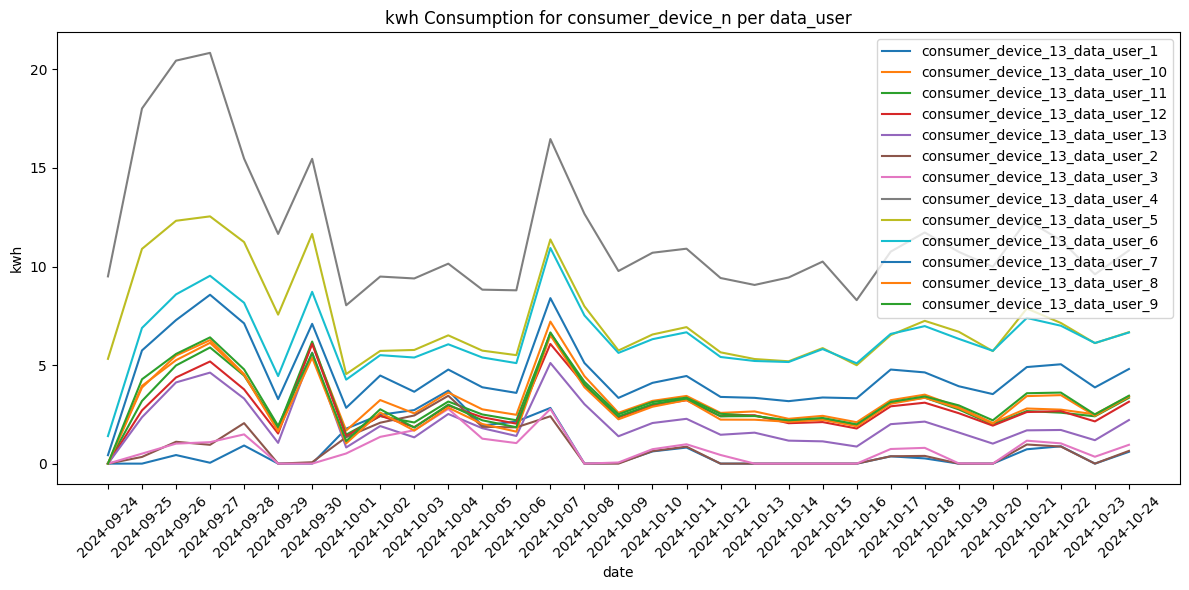

In [197]:

forecast_catboost_data_complete['Date'] = forecast_catboost_data_complete['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecast_catboost_data_complete['source'] = forecast_catboost_data_complete['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
consumer_n_data = forecast_catboost_data_complete[forecast_catboost_data_complete['source'].str.contains('consumer_device_13')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['source'].unique():
    user_data = consumer_n_data[consumer_n_data['source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_n per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


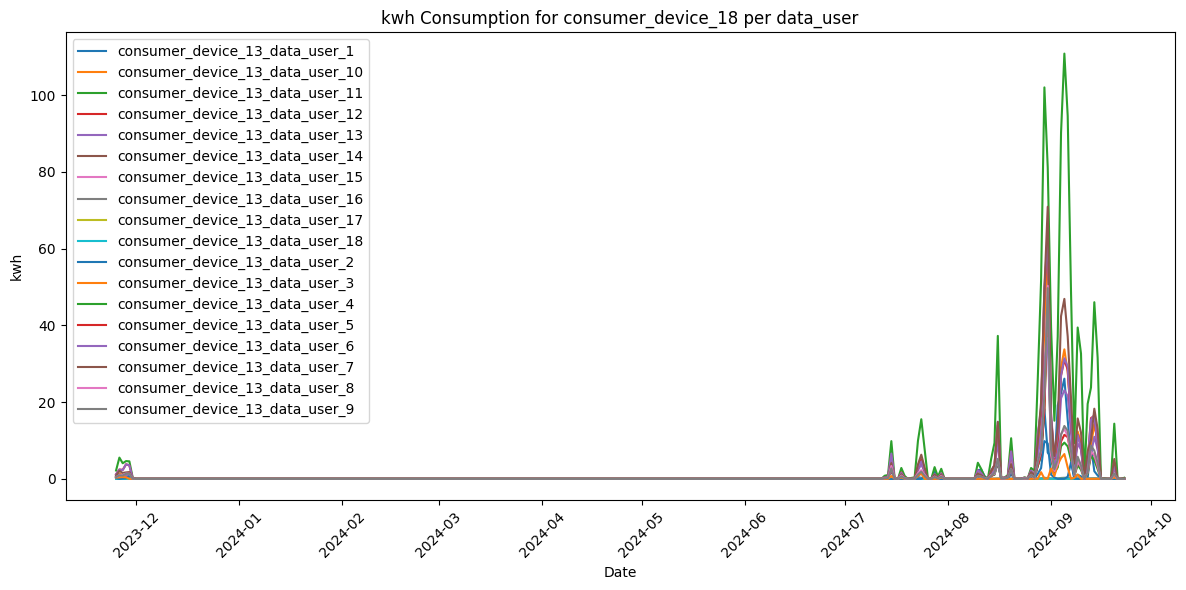

In [198]:
# CHECK OF THE DATA
consumer_18_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_13')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_18_data['Source'].unique():
    user_data = consumer_18_data[consumer_18_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_18 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


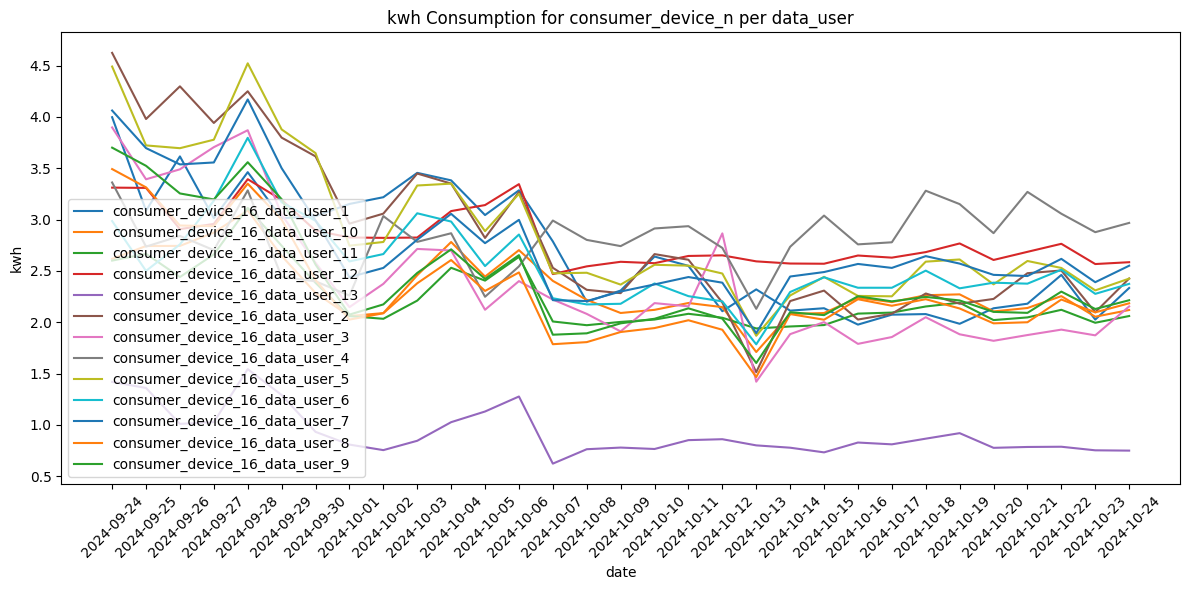

In [199]:

forecast_catboost_data_complete['Date'] = forecast_catboost_data_complete['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecast_catboost_data_complete['source'] = forecast_catboost_data_complete['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
consumer_n_data = forecast_catboost_data_complete[forecast_catboost_data_complete['source'].str.contains('consumer_device_16_')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['source'].unique():
    user_data = consumer_n_data[consumer_n_data['source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_n per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


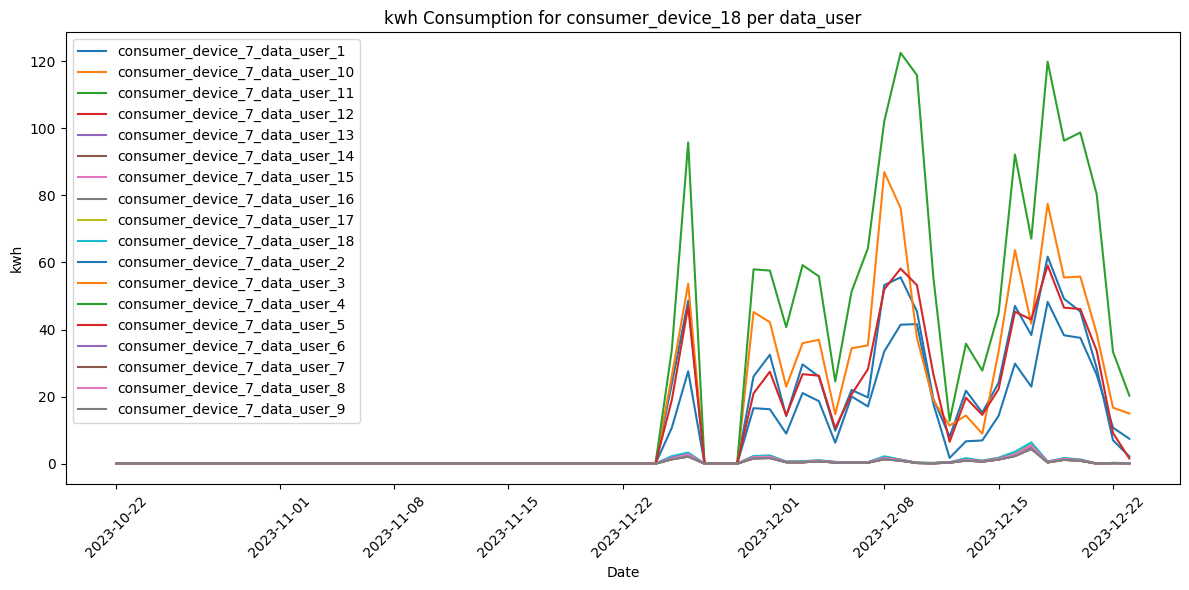

In [200]:
# CHECK OF THE DATA
consumer_18_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_7_')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_18_data['Source'].unique():
    user_data = consumer_18_data[consumer_18_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_18 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Public RMSE: ~6.83

### Observations and Insights

1. **Consumer Device Impact on RMSE**
   - After experimenting with multiple `consumer_device` groups, we observed that certain devices have a disproportionately large impact on the overall RMSE.
   - Conversely, many `consumer_devices` contribute very little to the error, often having `kwh` values close to zero.

2. **Distribution Shift in High-Consumption Devices**
   - In the training data, there is a noticeable shift in the consumption trend for high `kwh` devices during the last few months.
   - Earlier months show a different pattern compared to recent months, which can negatively affect the model's forecasting performance if not accounted for.

3. **Strategy Adjustment for High-Consumption Devices**
   - To better model these shifts, we propose training on only the most recent month (or two months) of data for high-consumption sources.
   - This localized training strategy aims to better align the model with the latest consumption behavior.

4. **Special Handling for `consumer_device` 18**
   - During validation, we found that CatBoost struggles to capture the distinctive trend in data from `consumer_device` 18.
   - Its consumption pattern shows a clear peak followed by a smooth decline, which the model fails to learn.
   - Therefore, we will implement a custom forecasting function tailored specifically to `consumer_device` 18 to handle this behavior more accurately.

### Next Steps
- Design trend-based training windows for high `kwh` sources.
- Create and apply a custom forecasting function for `consumer_device` 18.


In [201]:
# Filter rows where kwh > 20
high_kwh_sources = aggregated_data[aggregated_data['kwh'] > 30]['Source'].unique()

# Print each source
for source in high_kwh_sources:
    print(source)

consumer_device_10_data_user_10
consumer_device_10_data_user_6
consumer_device_10_data_user_9
consumer_device_12_data_user_5
consumer_device_12_data_user_6
consumer_device_13_data_user_10
consumer_device_13_data_user_11
consumer_device_13_data_user_12
consumer_device_13_data_user_13
consumer_device_13_data_user_4
consumer_device_13_data_user_5
consumer_device_13_data_user_6
consumer_device_13_data_user_7
consumer_device_13_data_user_8
consumer_device_13_data_user_9
consumer_device_18_data_user_10
consumer_device_18_data_user_11
consumer_device_18_data_user_12
consumer_device_18_data_user_4
consumer_device_18_data_user_5
consumer_device_18_data_user_6
consumer_device_18_data_user_7
consumer_device_18_data_user_8
consumer_device_18_data_user_9
consumer_device_19_data_user_3
consumer_device_19_data_user_5
consumer_device_21_data_user_10
consumer_device_21_data_user_3
consumer_device_21_data_user_5
consumer_device_23_data_user_2
consumer_device_23_data_user_4
consumer_device_25_data_user_1

In [202]:
# List of data sources (Source column values) identified as having consistently for high kWh consumption values.
# These sources are often statistical outliers or skew the average due to large consumption values,
# especially in the later parts of the dataset.
# They are used to selectively filter or handle data points (e.g., for exclusion or special modeling treatment).
### DELETED DEV 7 because it has bad impact on RMSE

sources_big=['consumer_device_10_data_user_10',
 'consumer_device_10_data_user_6',
 'consumer_device_10_data_user_9',
 'consumer_device_12_data_user_5',
 'consumer_device_12_data_user_6',
 'consumer_device_13_data_user_10',
 'consumer_device_13_data_user_11',
 'consumer_device_13_data_user_12',
 'consumer_device_13_data_user_13',
 'consumer_device_13_data_user_4',
 'consumer_device_13_data_user_5',
 'consumer_device_13_data_user_6',
 'consumer_device_13_data_user_7',
 'consumer_device_13_data_user_8',
 'consumer_device_13_data_user_9',
 'consumer_device_18_data_user_10',
 'consumer_device_18_data_user_11',
 'consumer_device_18_data_user_12',
 'consumer_device_18_data_user_4',
 'consumer_device_18_data_user_5',
 'consumer_device_18_data_user_6',
 'consumer_device_18_data_user_7',
 'consumer_device_18_data_user_8',
 'consumer_device_18_data_user_9',
 'consumer_device_21_data_user_10',
 'consumer_device_21_data_user_3',
 'consumer_device_21_data_user_5',
 'consumer_device_23_data_user_2',
 'consumer_device_23_data_user_4',
 'consumer_device_28_data_user_10',
 'consumer_device_28_data_user_16',
 'consumer_device_28_data_user_2',
 'consumer_device_28_data_user_5',
 'consumer_device_28_data_user_9',
 'consumer_device_29_data_user_3',
 'consumer_device_2_data_user_1',
 'consumer_device_30_data_user_4',
 'consumer_device_32_data_user_19',
 'consumer_device_32_data_user_5',
 'consumer_device_37_data_user_8'
 ]


In [203]:
# TRAIN with data without consumer_device 18 
# TRAIN with only data of the last 2 months for consumer_devices in sources_big (with high kwh) only not all the data 
# Create a DATA with the last criteria
DATA_no18= complete_data[complete_data['consumer_device'] != 18].copy()
DATA_no18 = DATA_no18[~((DATA_no18['Source'].isin(sources_big)) & (DATA_no18['Date'] < '2024-08-24'))]


In [204]:
# Ensure Date is datetime
DATA_no18["Date"] = pd.to_datetime(DATA_no18["Date"])

# Filter for the specific ID and check dates, check if it works
mask = (DATA_no18["Source"].str.contains("consumer_device_32_data_user_5")) & (DATA_no18["Date"] < "2024-08-24")
remaining_entries = DATA_no18[mask]

# Show the result
print(f"Remaining entries before 2024-08-24 for consumer_device_32_data_user_19: {len(remaining_entries)}")
print(remaining_entries)


Remaining entries before 2024-08-24 for consumer_device_32_data_user_19: 0
Empty DataFrame
Columns: [Date, Source, kwh, Temperature (°C), Dewpoint Temperature (°C), U Wind Component (m/s), V Wind Component (m/s), Total Precipitation (mm), Snowfall (mm), Snow Cover (%), consumer_device, data_user, year, day, is_weekend, day_of_week_sin, day_of_week_cos, month_sin, month_cos, week_of_year_sin, week_of_year_cos, quarter_sin, quarter_cos]
Index: []

[0 rows x 23 columns]


In [205]:
# TRAIN with last settings
model_CATNO18, X_train, X_test, y_train, y_test = train_catboost_model(DATA_no18)

Learning rate set to 0.022934
0:	learn: 3.3029719	test: 3.5544258	best: 3.5544258 (0)	total: 10.6ms	remaining: 2m 7s
1000:	learn: 1.9349711	test: 2.0944995	best: 2.0944995 (1000)	total: 9.1s	remaining: 1m 40s
2000:	learn: 1.6980177	test: 1.9043242	best: 1.9043242 (2000)	total: 17.4s	remaining: 1m 27s
3000:	learn: 1.5634372	test: 1.8051355	best: 1.8051355 (3000)	total: 25.7s	remaining: 1m 17s
4000:	learn: 1.4534844	test: 1.7338717	best: 1.7338717 (4000)	total: 33.7s	remaining: 1m 7s
5000:	learn: 1.3729229	test: 1.6815650	best: 1.6815507 (4999)	total: 42.1s	remaining: 59s
6000:	learn: 1.3088557	test: 1.6460984	best: 1.6460984 (6000)	total: 50.2s	remaining: 50.2s
7000:	learn: 1.2499650	test: 1.6142137	best: 1.6142137 (7000)	total: 58.4s	remaining: 41.7s
8000:	learn: 1.1972317	test: 1.5863823	best: 1.5863802 (7999)	total: 1m 6s	remaining: 33.2s
9000:	learn: 1.1520282	test: 1.5649382	best: 1.5649382 (9000)	total: 1m 14s	remaining: 24.8s
10000:	learn: 1.1084678	test: 1.5458760	best: 1.545876

In [206]:
import numpy as np
import pandas as pd

# Load sample submission and extract date
ss = pd.read_csv("SampleSubmission.csv")
ss["Date"] = pd.to_datetime(ss["ID"].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])

# Format climate data
climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])
climate_daily = climate_df.groupby(climate_df["Date Time"].dt.date).agg({
    "Temperature (°C)": "mean",
    "Dewpoint Temperature (°C)": "mean",
    "U Wind Component (m/s)": "mean",
    "V Wind Component (m/s)": "mean",
    "Total Precipitation (mm)": "sum",
    "Snowfall (mm)": "sum",
    "Snow Cover (%)": "mean",
}).reset_index()
climate_daily.rename(columns={"Date Time": "Date"}, inplace=True)
climate_daily["Date"] = pd.to_datetime(climate_daily["Date"])

# Merge with sample submission
forecast = ss.merge(climate_daily, on="Date", how="left")

# Extract consumer_device and data_user from ID
forecast["consumer_device"] = forecast["ID"].str.extract(r'consumer_device_(\d+)_data_user_\d+').astype(int)
forecast["data_user"] = forecast["ID"].str.extract(r'consumer_device_\d+_data_user_(\d+)').astype(int)

# Date feature engineering
forecast["Date"] = pd.to_datetime(forecast["Date"])
forecast["year"] = forecast["Date"].dt.year
forecast["day"] = forecast["Date"].dt.day
forecast["is_weekend"] = (forecast["Date"].dt.dayofweek >= 5).astype(int)

forecast["day_of_week_sin"] = np.sin(2 * np.pi * forecast["Date"].dt.dayofweek / 7)
forecast["day_of_week_cos"] = np.cos(2 * np.pi * forecast["Date"].dt.dayofweek / 7)

forecast["month_sin"] = np.sin(2 * np.pi * forecast["Date"].dt.month / 12)
forecast["month_cos"] = np.cos(2 * np.pi * forecast["Date"].dt.month / 12)

forecast["week_of_year_sin"] = np.sin(2 * np.pi * forecast["Date"].dt.isocalendar().week / 52)
forecast["week_of_year_cos"] = np.cos(2 * np.pi * forecast["Date"].dt.isocalendar().week / 52)

forecast["quarter_sin"] = np.sin(2 * np.pi * forecast["Date"].dt.quarter / 4)
forecast["quarter_cos"] = np.cos(2 * np.pi * forecast["Date"].dt.quarter / 4)

# Final feature matrix
X_test_final = forecast.drop(columns=['ID', 'kwh'], errors='ignore')
X_test_final.fillna(-1, inplace=True)

# Initialize submission DataFrame
forecast_cat_NO18 = ss.copy()
forecast_cat_NO18['kwh'] = 0.0  # Default to 0

# Get indices where consumer_device != 18
non_18_mask = forecast['consumer_device'] != 18

# Predict only for those entries
X_predict = X_test_final.loc[non_18_mask, X_train.columns]
forecast_cat_NO18.loc[non_18_mask, 'kwh'] = model_CATNO18.predict(X_predict).clip(min=0)

# Save to CSV
forecast_cat_NO18.to_csv("forecast-cat_base_no18.csv", index=False)

# Show final DataFrame
forecast_cat_NO18


,ID,kwh,Date
0,2024-09-24_consumer_device_12_data_user_1,0.000000,2024-09-24
1,2024-09-25_consumer_device_12_data_user_1,0.000000,2024-09-25
2,2024-09-26_consumer_device_12_data_user_1,0.000000,2024-09-26
3,2024-09-27_consumer_device_12_data_user_1,0.000000,2024-09-27
4,2024-09-28_consumer_device_12_data_user_1,0.000000,2024-09-28
...,...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.412863,2024-10-20
6010,2024-10-21_consumer_device_8_data_user_9,0.669931,2024-10-21
6011,2024-10-22_consumer_device_8_data_user_9,0.576170,2024-10-22
6012,2024-10-23_consumer_device_8_data_user_9,0.505151,2024-10-23


### After trainning Catboost without consumer_device 18 and keep only last 2 months data for big kwh sources
### Now we will handle the consumer_device 18 forecast seperately in the next function 

In [207]:
import pandas as pd
import numpy as np

def forecast_peak_then_decline_device18(all_data, forecast_horizon=30):
    """
    Custom forecasting strategy tailored for consumer_device 18.

    Motivation:
    -----------
    During the model evaluation phase, we observed that traditional forecasting models such as 
    CatBoost and ARIMA struggled to accurately capture the consumption behavior of consumer_device 18. 
    Specifically, these models failed to follow the distinct pattern of rising consumption followed 
    by a consistent decline observed in this device's historical data. Given this persistent 
    underperformance, we developed a custom heuristic model that better reflects the empirically 
    observed trend.

    Forecasting Strategy:
    ---------------------
    For each data_user under consumer_device 18:
    - Days 1 to 3: Simulate a short linear rise in consumption, from the last observed value up to 
      110% of that value.
    - Day 4: Maintain a short peak at this 110% value.
    - Days 5 to 30: Simulate a smooth linear decline from the peak value down to 13% of the original 
      last value. This reflects the consistent drop seen in the device’s typical usage pattern.

    Parameters:
    -----------
    all_data : pd.DataFrame
        A dataset containing at least the following columns:
        - 'consumer_device'
        - 'data_user'
        - 'Date'
        - 'kwh'

    forecast_horizon : int, optional (default=30)
        The total number of future days to forecast.

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing the custom forecast for each data_user under consumer_device 18, with:
        - 'ID': A string identifier of the form 'YYYY-MM-DD_consumer_device_18_data_user_{x}'
        - 'kwh': The forecasted consumption value for that day

    Notes:
    ------
    - This function is specifically designed for consumer_device 18 due to its atypical trend.
    - The peak and decline phases are linear to maintain interpretability and simplicity.
    - This method assumes daily data and extrapolates linearly from the last known point.
    """

    forecast_results = []

    # Filter for consumer_device 18
    device_data = all_data[all_data['consumer_device'] == 18].copy()

    for data_user, user_group in device_data.groupby('data_user'):
        user_group = user_group.sort_values('Date')
        last_val = user_group['kwh'].iloc[-1]
        peak_val = last_val * 1.1
        final_val = last_val * 0.13  # Simulates sharp decline

        # Phase 1: Days 1–3 (4 points, including start and peak)
        phase1 = np.linspace(last_val, peak_val, 4)

        # Phase 2: Day 4 (flat peak)
        phase2 = np.array([peak_val])

        # Phase 3: Days 5–30 (remaining points)
        decline_days = forecast_horizon - len(phase1) - len(phase2)
        phase3 = np.linspace(peak_val, final_val, decline_days)

        # Combine all phases
        kwh_forecast = np.concatenate([phase1, phase2, phase3])

        # Forecast dates
        forecast_dates = pd.date_range(start=user_group['Date'].max() + pd.Timedelta(days=1), 
                                       periods=forecast_horizon, freq='D')

        forecast_ids = [
            f"{date.strftime('%Y-%m-%d')}_consumer_device_18_data_user_{data_user}"
            for date in forecast_dates
        ]

        forecast_df = pd.DataFrame({
            'ID': forecast_ids,
            'kwh': kwh_forecast
        })

        forecast_results.append(forecast_df)

    return pd.concat(forecast_results, ignore_index=True)


In [208]:
forecast_18_only=forecast_peak_then_decline_device18(all_data=complete_data, forecast_horizon=30)

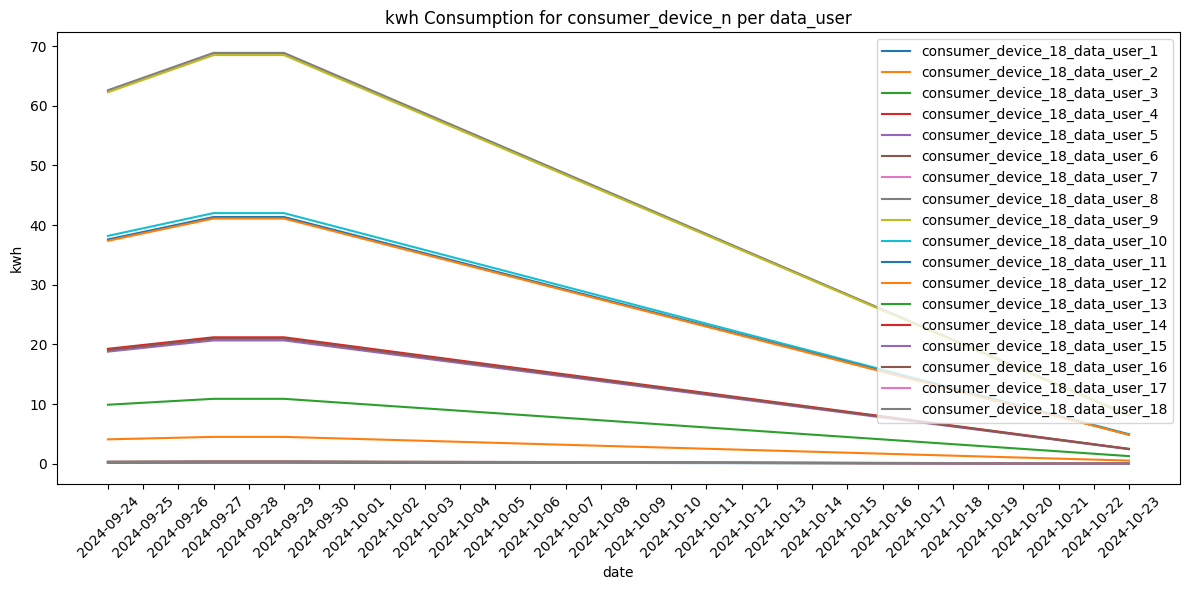

In [209]:
# Filter data for consumer_device_10
forecast_18_only['date'] = forecast_18_only['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecast_18_only['source'] = forecast_18_only['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
consumer_n_data = forecast_18_only[forecast_18_only['source'].str.contains('consumer_device_18')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_n_data['source'].unique():
    user_data = consumer_n_data[consumer_n_data['source'] == data_user]
    plt.plot(user_data['date'], user_data['kwh'], label=data_user)

plt.xlabel('date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_n per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [210]:
forecast_18_only

,ID,kwh,date,source
0,2024-09-24_consumer_device_18_data_user_1,0.197634,2024-09-24,consumer_device_18_data_user_1
1,2024-09-25_consumer_device_18_data_user_1,0.204222,2024-09-25,consumer_device_18_data_user_1
2,2024-09-26_consumer_device_18_data_user_1,0.210809,2024-09-26,consumer_device_18_data_user_1
3,2024-09-27_consumer_device_18_data_user_1,0.217397,2024-09-27,consumer_device_18_data_user_1
4,2024-09-28_consumer_device_18_data_user_1,0.217397,2024-09-28,consumer_device_18_data_user_1
...,...,...,...,...
535,2024-10-19_consumer_device_18_data_user_18,0.085891,2024-10-19,consumer_device_18_data_user_18
536,2024-10-20_consumer_device_18_data_user_18,0.073989,2024-10-20,consumer_device_18_data_user_18
537,2024-10-21_consumer_device_18_data_user_18,0.062087,2024-10-21,consumer_device_18_data_user_18
538,2024-10-22_consumer_device_18_data_user_18,0.050185,2024-10-22,consumer_device_18_data_user_18


In [211]:
#forecast_18_only.rename(columns={'kwh_arima_18': 'kwh'}, inplace=True)
forecast_18 = pd.read_csv("SampleSubmission.csv")

# Set ID as index for both DataFrames
forecast_18.set_index("ID", inplace=True)
forecast_18_only.set_index("ID", inplace=True)

# Update forecast_18 with predicted kwh values where IDs match
forecast_18.update(forecast_18_only[["kwh"]])

# Reset index if needed
forecast_18.reset_index(inplace=True)


In [212]:
# Merge CatBoost forecast catboostNO18 and forecast_18 on 'ID'
forecast_cat_NO18['date'] = forecast_cat_NO18['ID'].str.extract(r'^(\d{4}-\d{2}-\d{2})')
forecast_cat_NO18['source'] = forecast_cat_NO18['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')
combined_forecast = forecast_cat_NO18.merge(forecast_18[['ID', 'kwh']], on='ID', how='left', suffixes=('_cat', '_18'))

# Extract consumer_device and source from ID
combined_forecast['consumer_device'] = combined_forecast['ID'].str.extract(r'consumer_device_(\d+)').astype(int)
combined_forecast['source'] = combined_forecast['ID'].str.extract(r'^\d{4}-\d{2}-\d{2}_(.+)')

combined_forecast

,ID,kwh_cat,Date,date,source,kwh_18,consumer_device
0,2024-09-24_consumer_device_12_data_user_1,0.000000,2024-09-24,2024-09-24,consumer_device_12_data_user_1,0.0,12
1,2024-09-25_consumer_device_12_data_user_1,0.000000,2024-09-25,2024-09-25,consumer_device_12_data_user_1,0.0,12
2,2024-09-26_consumer_device_12_data_user_1,0.000000,2024-09-26,2024-09-26,consumer_device_12_data_user_1,0.0,12
3,2024-09-27_consumer_device_12_data_user_1,0.000000,2024-09-27,2024-09-27,consumer_device_12_data_user_1,0.0,12
4,2024-09-28_consumer_device_12_data_user_1,0.000000,2024-09-28,2024-09-28,consumer_device_12_data_user_1,0.0,12
...,...,...,...,...,...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.412863,2024-10-20,2024-10-20,consumer_device_8_data_user_9,0.0,8
6010,2024-10-21_consumer_device_8_data_user_9,0.669931,2024-10-21,2024-10-21,consumer_device_8_data_user_9,0.0,8
6011,2024-10-22_consumer_device_8_data_user_9,0.576170,2024-10-22,2024-10-22,consumer_device_8_data_user_9,0.0,8
6012,2024-10-23_consumer_device_8_data_user_9,0.505151,2024-10-23,2024-10-23,consumer_device_8_data_user_9,0.0,8


In [213]:
# Postprocessing: Adjust CatBoost forecast per consumer_device scaling logic
# This step applies empirical scaling factors to account for systematic over/under-prediction
# observed for certain devices. This is a post-model adjustment (not learned from data).

# Create a new DataFrame based on the combined forecast
adjusted_max_forecast = combined_forecast.copy()

# Apply scaling factors or override with alternative model output based on consumer_device
adjusted_max_forecast['kwh'] = adjusted_max_forecast.apply(
    lambda row:
    (row['kwh_cat'] * 0.92) if row["consumer_device"] == 13  # Scale down CatBoost prediction for device 13
    else (row['kwh_cat'] * 0.9) if row["consumer_device"] == 21  # Scale down for device 21
    else row['kwh_18'] if row["consumer_device"] == 18  # Use alternate model for device 18
    else row['kwh_cat'],  # Default: use CatBoost prediction as-is
    axis=1
)

# Keep only ID and adjusted kwh forecast
adjusted_max_forecast = adjusted_max_forecast[['ID', 'kwh']]


In [214]:
adjusted_max_forecast

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.000000
1,2024-09-25_consumer_device_12_data_user_1,0.000000
2,2024-09-26_consumer_device_12_data_user_1,0.000000
3,2024-09-27_consumer_device_12_data_user_1,0.000000
4,2024-09-28_consumer_device_12_data_user_1,0.000000
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.412863
6010,2024-10-21_consumer_device_8_data_user_9,0.669931
6011,2024-10-22_consumer_device_8_data_user_9,0.576170
6012,2024-10-23_consumer_device_8_data_user_9,0.505151


In [215]:
check_save_pred(forecast_pred=adjusted_max_forecast, data=complete_data, sss=ss, file_name="BEST_SUBMISSION.csv")

                                          ID  kwh
0  2024-09-24_consumer_device_12_data_user_1  0.0
1  2024-09-25_consumer_device_12_data_user_1  0.0
2  2024-09-26_consumer_device_12_data_user_1  0.0
3  2024-09-27_consumer_device_12_data_user_1  0.0
4  2024-09-28_consumer_device_12_data_user_1  0.0
136409 6014 6014
IDs in 'forecast' but not in 'ss':
set()

IDs in 'ss' but not in 'forecast':
set()

Number of IDs that differ: 0
